Keras, model eğitimi sırasında training ve validation loss'ları kaydeder. Bu derste, bu learning curve'leri yorumlamayı ve model geliştirmede kullanmayı öğreneceğiz. Underfitting ve overfitting belirtilerini inceleyip, bu sorunları çözmek için stratejiler üzerinde duracağız.

**Learning Curve'leri Yorumlama**

Training datadaki bilgiyi iki türde düşünebilirsiniz: signal ve noise. Signal, genelleşebilen ve modelin yeni verilerden tahmin yapmasına yardımcı olan kısımdır. Noise ise sadece training dataya özgü olan, gerçek dünyadaki rastgele dalgalanmalardan veya aslında yararlı olmayan ancak öyle görünen bilgilerden oluşan kısımdır.

Bir modeli, training set üzerindeki loss'u minimize edecek weight'leri veya parametreleri seçerek eğitiriz. Ancak, bir modelin performansını doğru değerlendirmek için yeni bir veri seti olan validation data üzerinde değerlendirme yapmamız gerektiğini biliyorsunuz. (Bu konuyu gözden geçirmek için Introduction to Machine Learning dersindeki model validation bölümüne bakabilirsiniz.)

When we train a model we've been plotting the loss on the training set epoch by epoch. To this we'll add a plot the validation data too. These plots we call the learning curves. Derin öğrenme modellerini etkili bir şekilde eğitmek için onları yorumlayabilmemiz gerekir.

![](image14.png)

Training loss; model, signal veya noise öğrendiğinde düşer. Ancak validation loss sadece model, signal öğrendiğinde düşer. (Training set'ten öğrenilen noise yeni veriye genelleşmez.) Yani; model, signal öğrendiğinde her iki eğri de düşer, ancak noise öğrendiğinde eğriler arasında bir boşluk oluşur. Bu boşluğun büyüklüğü, modelin ne kadar noise öğrendiğini gösterir. --The size of the gap tells you how much noise the model has learned.

İdeal olarak, tüm signal'i öğrenen ve hiç noise öğrenmeyen modeller oluşturmak isteriz. Bu pratikte neredeyse imkansızdır. Bunun yerine bir denge kurarız. Modele daha fazla noise öğrenme pahasına daha fazla signal öğretebiliriz. Bu denge lehimize olduğu sürece, validation loss düşmeye devam eder. Ancak belli bir noktadan sonra, bu denge aleyhimize dönebilir, maliyet faydayı aşar ve validation loss yükselmeye başlar.

![](image15.png)

Bu denge, model eğitiminde iki sorun olabileceğini gösterir: yetersiz signal veya aşırı noise. Underfitting, model yeterince signal öğrenmediği için loss'un olması gerektiği kadar düşük olmadığı durumdur. Overfitting ise model çok fazla noise öğrendiği için loss'un olması gerektiği kadar düşük olmadığı durumdur. **Deep learning modellerini eğitmenin püf noktası, bu ikisi arasında en iyi dengeyi bulmaktır.**

Training data'dan daha fazla signal elde ederken noise miktarını azaltmanın birkaç yolunu inceleyeceğiz.

**Capacity**

Bir modelin capacity'si, öğrenebileceği pattern'ların boyutunu ve karmaşıklığını ifade eder. Neural network'ler için bu, büyük ölçüde sahip olduğu neuron sayısına ve bunların nasıl bağlandığına bağlıdır. Eğer network'ünüz underfitting yapıyorsa, capacity'sini artırmayı denemelisiniz.

Bir network'ün capacity'sini, onu daha geniş (mevcut layer'lara daha fazla unit ekleyerek) veya daha derin (daha fazla layer ekleyerek) yaparak artırabilirsiniz. Geniş network'ler daha linear ilişkileri, derin network'ler ise daha nonlinear ilişkileri öğrenmekte daha iyidir. Hangisinin daha iyi olduğu dataset'e bağlıdır.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
model = keras.Sequential([
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1),
])

deeper = keras.Sequential([
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1),
])

wider = keras.Sequential([
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=1),
])

**Early Stopping**

Bir model noise'u çok hevesle öğrendiğinde, validation loss eğitim sırasında artmaya başlayabilir. Bunu önlemek için, validation loss'un artık düşmediği görüldüğünde eğitimi durdurabiliriz. Eğitimi bu şekilde kesintiye uğratmaya early stopping denir.

![](image16.png)

Validation loss'un tekrar yükselmeye başladığını tespit ettiğimizde, weight'leri minimum noktasına geri döndürebiliriz. Bu, modelin noise öğrenmeye devam etmesini ve data'yı overfit etmesini engeller.

Early stopping ile eğitim, network signal öğrenmeyi bitirmeden eğitimi çok erken durdurma tehlikesini de azaltır. Yani early stopping, çok uzun süre eğitimden kaynaklanan overfitting'i önlemenin yanı sıra, yetersiz eğitimden kaynaklanan underfitting'i de önleyebilir. Eğitim epoch'larını büyük bir sayıya ayarlayın (ihtiyacınızdan fazla) ve early stopping gerisini halledecektir.

Keras'ta, erken durdurma için bir callback kullanılır. Bu callback, her epoch sonunda çalışarak modelin durmasını gerektiren bir koşul olup olmadığını kontrol eder.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

Bu parametreler, "Eğer önceki 20 epoch boyunca doğrulama kaybında en az 0.001'lik bir iyileşme olmadıysa, eğitimi durdur ve bulduğun en iyi modeli sakla" anlamına gelir. Doğrulama kaybının aşırı öğrenmeden mi yoksa rastgele batch dalgalanmalarından mı arttığını anlamak bazen zor olabilir. Bu parametreler, eğitimi ne zaman durduracağımız konusunda bize esneklik sağlar.

Örneğimizde, bu callback'i loss ve optimizer ile birlikte fit metoduna ileteceğiz.

**ÖRNEK**

Let's continue developing the model from the example in the last tutorial. We'll increase the capacity of that network but also add an early-stopping callback to prevent overfitting.

Here's the data prep again.

In [10]:
import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('C:/Users/Alperen Arda/OneDrive/Desktop/GitHub/Data-Science-and-Machine-Learning-Tutorial/Datasets/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


Şimdi ağın kapasitesini artıracağız. Oldukça büyük bir ağ oluşturacağız, ancak doğrulama kaybı artış belirtileri gösterdiğinde eğitimi durdurmak için callback'e güveneceğiz.

In [11]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

c:\Users\Alperen Arda\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Callback'ı tanımladıktan sonra, onu fit fonksiyonuna argüman olarak ekleyin (birden fazla callback ekleyebilirsiniz, bu yüzden bir liste içinde yerleştirin). Early stopping kullanırken, ihtiyacınızdan daha fazla epoch seçin.

Minimum validation loss: 0.09427440911531448


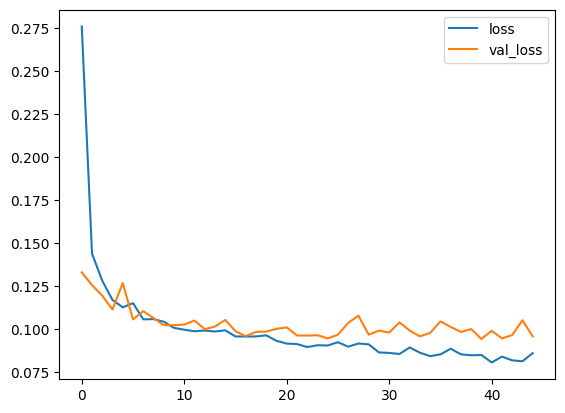

In [12]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Ve tabii ki Keras, eğitimi tam 500 epochsun çok öncesinde durdurdu!